SAIDL 2024 Spring Assignment

Author: Shanay Mehta

**Packages:**

In [1]:
import torch
from torch import nn
from torch.optim import *
from torchvision.datasets import *
from torchvision.transforms import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

**Device:**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
torch.random.manual_seed(1)
np.random.seed(1)

**Loading the CIFAR 10 Dataset:**

In [4]:
image_size = 32
transforms = {
    # Data augmentation and normalisation
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #normalise according to the
    ]),
    "test": Compose([
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )


Files already downloaded and verified
Files already downloaded and verified


**Display image**

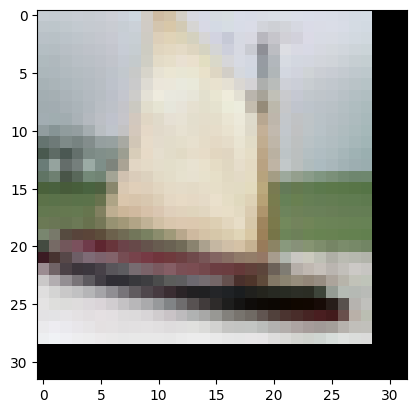

torch.Size([3, 32, 32])
tensor(8)


In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# printing images
dataiter = iter(dataloader['train'])
images, labels = next(dataiter)

imshow(images[0])
print(images[0].shape)
print(labels[0])

**Train and Test functions**

In [6]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  l2_lambda: float = 0.005,
) -> float:
  model.train()

  total_loss = 0.0

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # L2 regularization
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param)**2
    loss += 0.5 * l2_lambda * l2_reg

    total_loss += loss.item() * inputs.size(0)

    # Backward propagation
    loss.backward()

    # Update optimizer
    optimizer.step()
  return total_loss/len(dataloader.dataset)

In [7]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

**VGG Model**

In [8]:
# Code for the VGG16 class has been taken from: https://blog.paperspace.com/vgg-from-scratch-pytorch/
# This is done because VGG16 is a standard model and it is not the main focus of this project
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Linear(16*256, 1600),
            nn.Dropout(0.5),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Linear(1600, 1000),
            nn.Dropout(0.5),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(1000, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [9]:
model = VGG16().to(device)

In [10]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [11]:
def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

In [12]:
def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

In [13]:
model_size= get_model_size(model, data_width=32, count_nonzero_only=False)/(8*1024*1024)
print(f"Model size: {model_size:.2f} MiB")

Model size: 37.78 MiB


In [14]:
# Save the model to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
weights_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'

**Training the model**

Training process has been shown in the other file which is submitted in the Pruning folder

In [16]:
# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=0.001)

# weights_history = []
# accuracy_history = []
# loss_history = []

# num_epochs = 60
# best_accuracy = 0.0

# for epoch in range(num_epochs):
#     loss = train(model, dataloader['train'], criterion, optimizer)
#     accuracy = evaluate(model, dataloader['test'])

#     if accuracy > best_accuracy:
#         torch.save(model.state_dict(), weights_path)
#         best_accuracy = accuracy

#     if epoch == 19:
#       optimizer = Adam(model.parameters(), lr=0.0005) # Based on observation

#     elif epoch == 39:
#       optimizer = Adam(model.parameters(), lr=0.0001) # Based on observation

#     print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {accuracy:.2f}%, Train Loss: {loss:.4f}")

In [17]:
# Load the saved model
load_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'
loaded_model = VGG16().to(device)
loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
print(f"Model loaded from {load_path}")

Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


In [18]:
accuracy = evaluate(loaded_model, dataloader['test'])
print(f"Test Accuracy: {accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 91.09%


**Bonus Task:**
Plotting weight distribution

In [19]:
def plot_weight_distribution(model):
    num_layers = 10
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))
    r = 0
    c = 0
    for i, (name, param) in enumerate(model.named_parameters()):
        if len(param.size()) > 1:  # Exclude biases
            weights = param.cpu().detach().numpy().flatten()
            axs[r, c].hist(weights, bins=50, color='blue', alpha=0.7)
            axs[r, c].set_title(f'Layer {name}')
            axs[r, c].set_xlabel('Weight Value')
            axs[r, c].set_ylabel('Frequency')
            axs[r, c].grid(True)
            c+=1
            if(c==3):
              r+=1
              c=0

    plt.tight_layout()
    plt.show()

Note the scale of frequency on y-axis

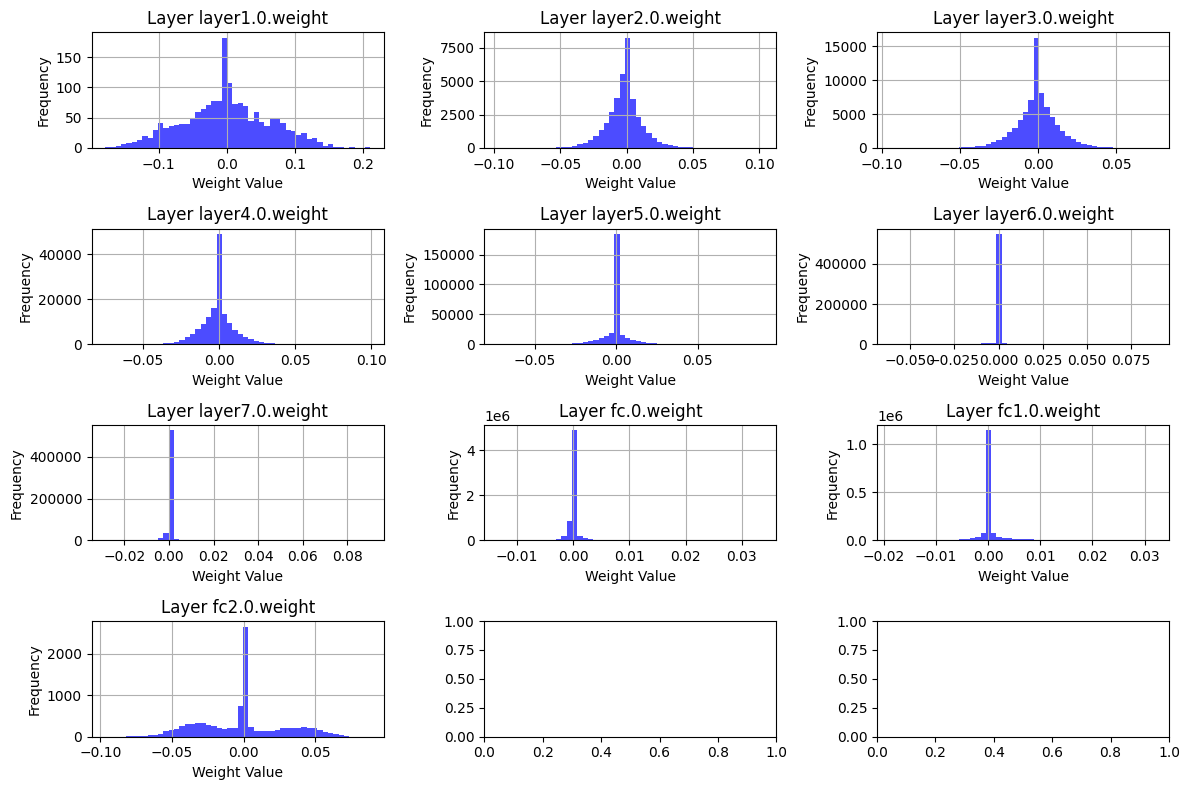

In [20]:
# Plot the weight distribution of the loaded model
plot_weight_distribution(loaded_model)

Checking the balance of activations for un-pruned model upon passage of input for 1st batch in the test set

In [21]:
def check_activation(model, dataloader):
    activations = {}
    x = next(iter(dataloader))[0]
    x = x.to(device)
    for name, layer in model.named_children():
        print(name)
        if (name == 'fc'):
            x = x.view(x.size(0), -1)  # Flatten the tensor
        x = layer(x)
        activations[name] = x.cpu().detach().numpy().flatten()

    # Plot histograms of activations for each layer
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))
    for i, (name, activation) in enumerate(activations.items()):
        row = i // 3
        col = i % 3
        axs[row, col].hist(activation, bins=50, color='blue', alpha=0.7)
        axs[row, col].set_title(f'Layer {name}')
        axs[row, col].set_xlabel('Activation Value')
        axs[row, col].set_ylabel('Frequency')
        axs[row, col].grid(True)

    plt.tight_layout()
    plt.show()

layer1
layer2
layer3
layer4
layer5
layer6
layer7
fc
fc1
fc2


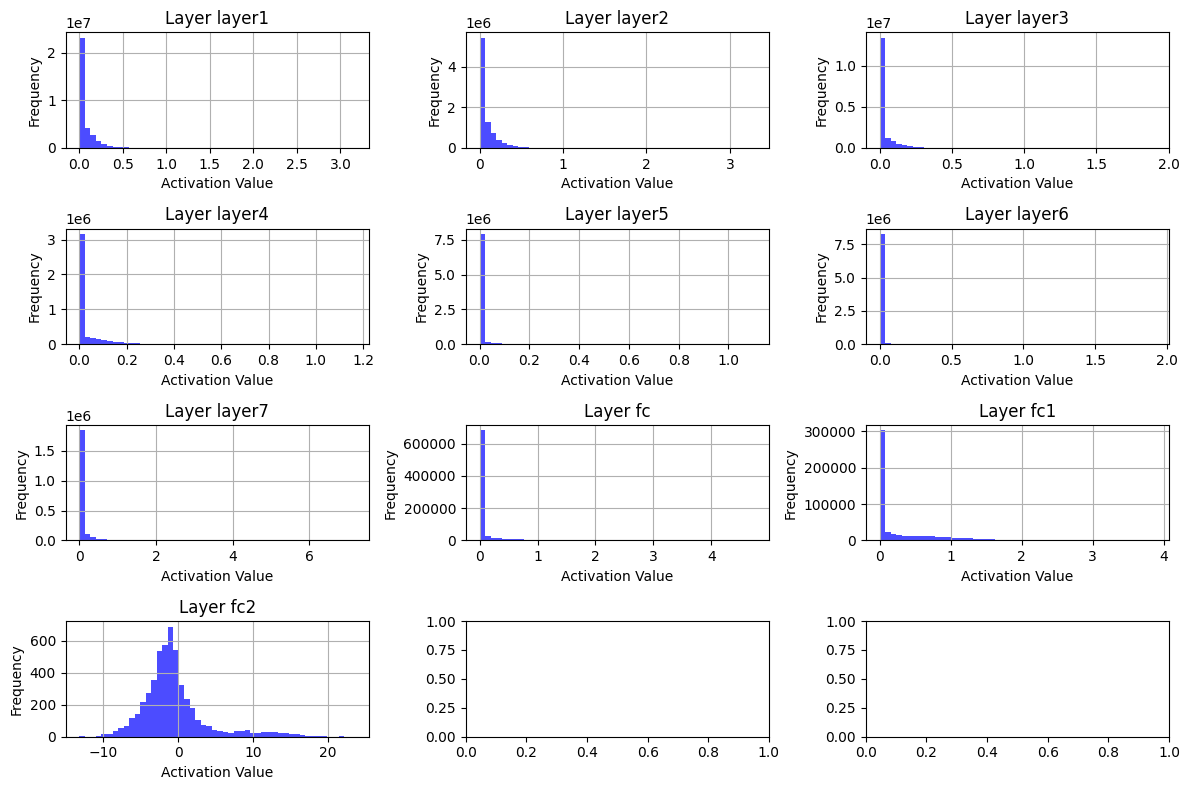

In [22]:
check_activation(loaded_model, dataloader['test'])

**Pruning**

In [23]:
def prune_layer(model: nn.Module, layer_name: str, prune_percent: float):
    """
    Prune a specified percentage of weights in a layer using argmin method.
    :param model: The model to be pruned.
    :param layer_name: The name of the layer to be pruned.
    :param prune_percent: The percentage of weights to be pruned.
    """
    layer = getattr(model, layer_name)
    weights = layer[0].weight.data # I have only pruned the weights of layer[0] because it contains the majority of weights for that particular layer
    num_weights = weights.numel()
    num_prune = int(num_weights * prune_percent)
    flat_weights = weights.view(-1)
    _, indices = torch.topk(torch.abs(flat_weights), num_prune, largest=False)
    flat_weights[indices] = 0.0
    weights.data = flat_weights.view(weights.size())

**Sensitivity Scan**

Sensitivity Scan has been shown in the other file which is submitted in the Pruning folder

In [24]:
# # Plot accuracy vs. pruning percentage for all layers
# layer_names = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'fc', 'fc1', 'fc2']
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'brown']
# prune_per = list(range(0, 91, 10))
# accuracy_values = [[] for _ in range(len(layer_names))]

# for layer_idx, layer_name in enumerate(layer_names):
#     for prune_percent in prune_per:
#         # Load the saved model
#         load_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'
#         loaded_model = VGG16().to(device)
#         loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
#         print(f"Model loaded from {load_path}")
#         # Prune the specified percentage of the layer
#         prune_layer(loaded_model, layer_name, prune_percent / 100.0)
#         # Evaluate the pruned model
#         accuracy = evaluate(loaded_model, dataloader['test'])
#         print(f"Test Accuracy with {prune_percent}% pruning for {layer_name}: {accuracy:.2f}%")
#         accuracy_values[layer_idx].append(accuracy)


In [25]:
# # Plotting
# plt.figure(figsize=(10, 6))
# for layer_idx, layer_name in enumerate(layer_names):
#     plt.plot(prune_per, accuracy_values[layer_idx], color=colors[layer_idx], label=layer_name)

# for layer_idx, layer_name in enumerate(layer_names):
#     plt.scatter(prune_per, accuracy_values[layer_idx], color=colors[layer_idx])

# plt.xlabel('Pruning Percentage (%)')
# plt.ylabel('Test Accuracy (%)')
# plt.title('Accuracy vs. Pruning Percentage for All Layers')
# plt.legend()
# plt.grid(True)
# plt.show()

Modified the prune_layer function to return mask of the parameters pruned

In [26]:
def prune_layer_mod(model: nn.Module, layer_name: str, prune_percent: float):
    """
    Prune a specified percentage of weights in a layer using argmin method.
    :param model: The model to be pruned.
    :param layer_name: The name of the layer to be pruned.
    :param prune_percent: The percentage of weights to be pruned.
    """
    layer = getattr(model, layer_name)
    weights = layer[0].weight.data
    num_weights = weights.numel()
    num_prune = int(num_weights * prune_percent)
    flat_weights = weights.view(-1)
    _, indices = torch.topk(torch.abs(flat_weights), num_prune, largest=False)
    flat_weights[indices] = 0.0
    mask = torch.ones_like(flat_weights)
    # Set 0s at indices to be pruned
    mask[indices] = 0.0
    weights.data = flat_weights.view(weights.size())
    mask = mask.view(weights.size())
    return mask

In [27]:
load_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'
loaded_model = VGG16().to(device)
loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
print(f"Model loaded from {load_path}")

Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


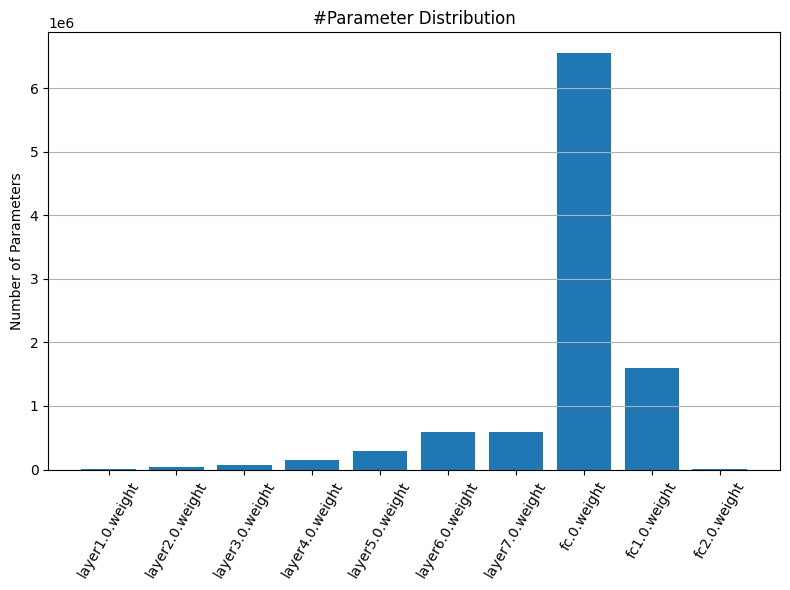

In [28]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(loaded_model)

**Criteria for selecting how much of each layer to prune**:

1. **Accuracy**: We need to ensure that accuracy of the pruned model does not drop below a certain threshold(decide based on sensitivity scan)

2. **Percentage of params in the layer**: A layer which contains a very small percentage of params(percentage taken w.r.t the number of params in the entire model) should not be pruned much since it wont have a big effect on the model size. However, a layer which accounts for a big percentage should be pruned as much as possible. This leads to the conclusion that fully connected layers should be pruned more as compared to conv layers

**Pruning the loaded model**

In [29]:
masks = dict()
masks['layer1.0.weight'] = prune_layer_mod(loaded_model, 'layer1', 0.0 / 100.0)
masks['layer2.0.weight'] = prune_layer_mod(loaded_model, 'layer2', 0.0 / 100.0)
masks['layer3.0.weight'] = prune_layer_mod(loaded_model, 'layer3', 0.0 / 100.0)
masks['layer4.0.weight'] = prune_layer_mod(loaded_model, 'layer4', 0.0 / 100.0)
masks['layer5.0.weight'] = prune_layer_mod(loaded_model, 'layer5', 90.0 / 100.0)
masks['layer6.0.weight'] = prune_layer_mod(loaded_model, 'layer6', 90.0 / 100.0)
masks['layer7.0.weight'] = prune_layer_mod(loaded_model, 'layer7', 90.0 / 100.0)
masks['fc.0.weight'] = prune_layer_mod(loaded_model, 'fc', 95.0 / 100.0)
masks['fc1.0.weight'] = prune_layer_mod(loaded_model, 'fc1', 95.0 / 100.0)
masks['fc2.0.weight'] = prune_layer_mod(loaded_model, 'fc2', 90.0 / 100.0)

In [30]:
model_size= get_model_size(loaded_model, data_width=32, count_nonzero_only=True)/(8*1024*1024)
print(f"Pruned model size: {model_size:.2f} MiB")

Pruned model size: 3.14 MiB


In [31]:
# Evaluate the pruned model
accuracy = evaluate(loaded_model, dataloader['test'])
print(f"Test Accuracy with pruned model of size {model_size:.2f} MiB: {accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with pruned model of size 3.14 MiB: 85.22%


*Note: The model size was initially 37.78 MiB with an accuracy of 91.09% and the size of the pruned model is 3.14 MiB(Approximately 10 times smaller) with an accuracy of 85.22%. **

The reduction in size of the model is huge however the reduction in accuracy is very small. This is because the percentage of pruning for each layer has been carefully chosen based on the factors listed above.

In [32]:
def plot_pruned_weight_distribution(model, masks):
    num_layers = 10
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))
    r = 0
    c = 0
    for i, (name, param) in enumerate(model.named_parameters()):
        if len(param.size()) > 1:  # Exclude biases
            weights = param.cpu().detach().numpy().flatten()
            # Apply mask to weights array
            pruned_weights = weights[masks[name].cpu().flatten() != 0]
            axs[r, c].hist(pruned_weights, bins=50, color='blue', alpha=0.7)
            axs[r, c].set_title(f'Layer {name}')
            axs[r, c].set_xlabel('Weight Value')
            axs[r, c].set_ylabel('Frequency')
            axs[r, c].grid(True)
            c+=1
            if(c==3):
              r+=1
              c=0

    plt.tight_layout()
    plt.show()

**Note the change in scale of frequency at the y-axis for pruned model vs un-pruned model**

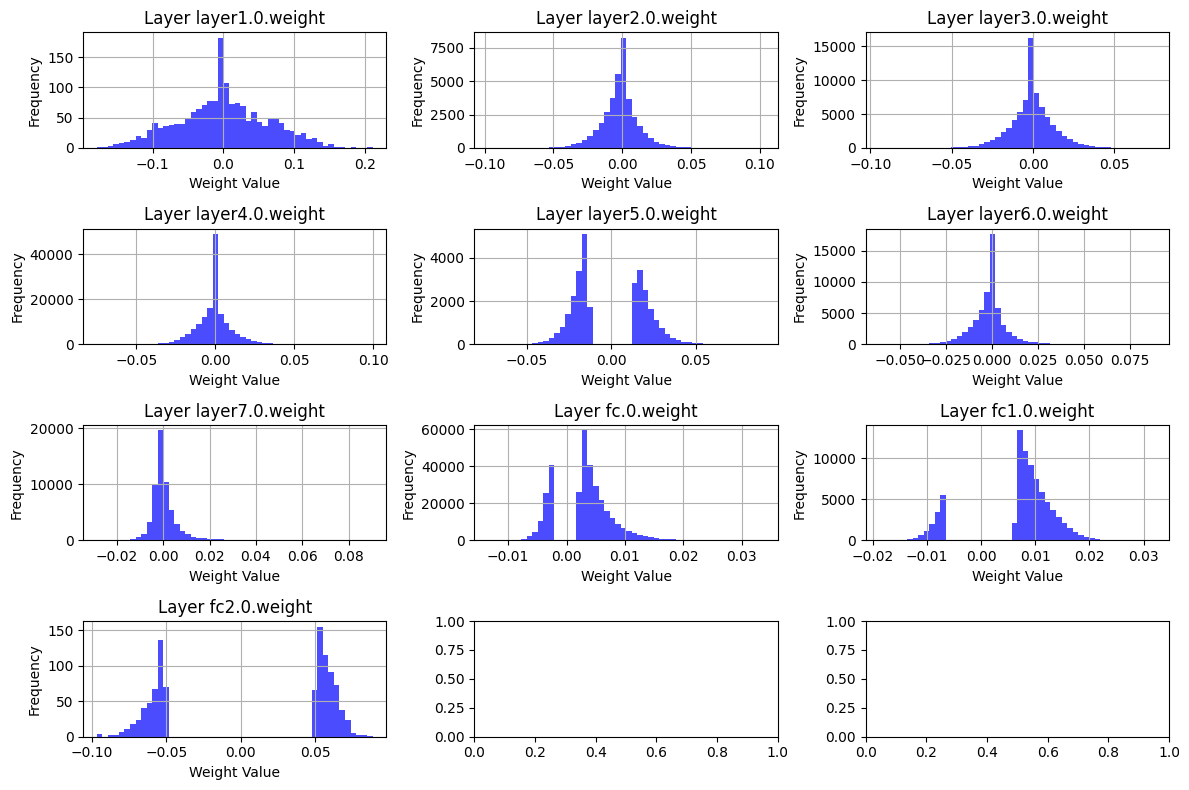

In [33]:
plot_pruned_weight_distribution(loaded_model.to('cpu'), masks)

Checking the balance of activations for pruned model upon passage of input for 1st batch in the test set

layer1
layer2
layer3
layer4
layer5
layer6
layer7
fc
fc1
fc2


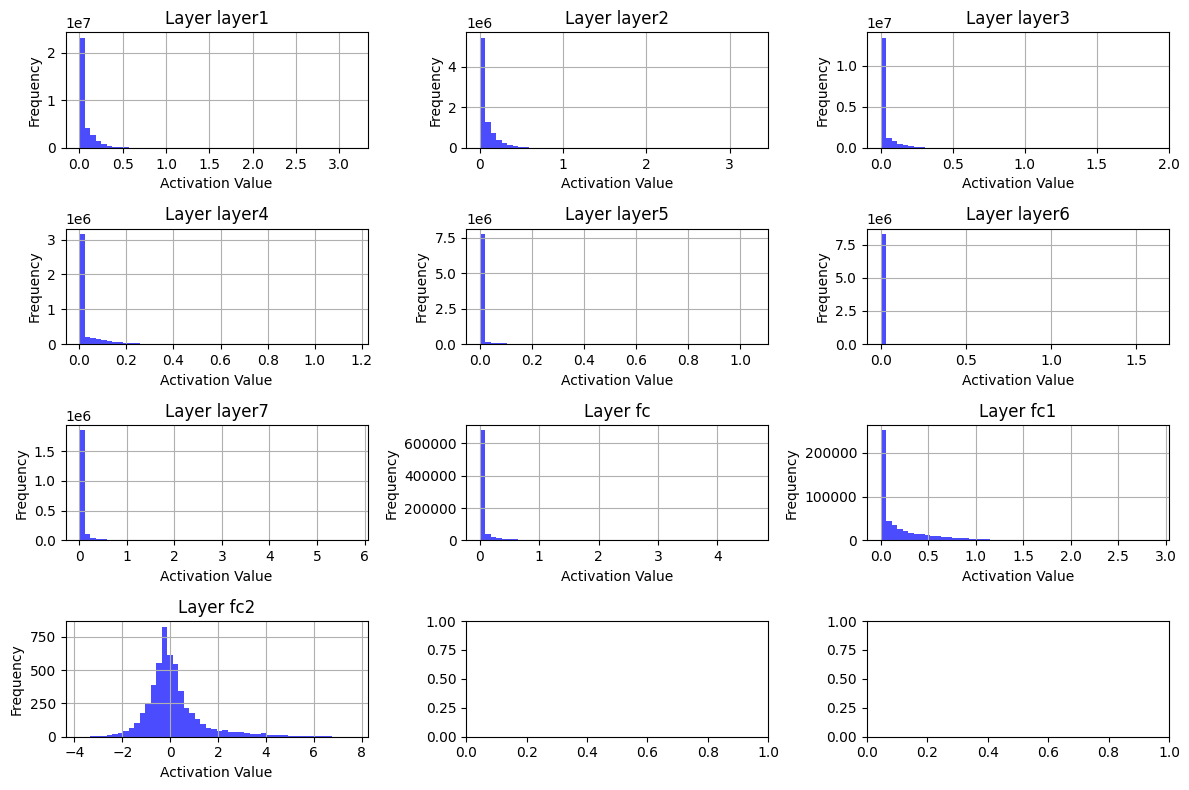

In [34]:
check_activation(loaded_model.to('cuda'), dataloader['test'])

**Fine-Tuning**

Modify the train function to include masks for fine-tuning without affecting the pruned synapses

In [35]:
def train_ft(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  l2_lambda: float = 0.005,
  callbacks = None
) -> float:
  model.train()

  total_loss = 0.0

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # L2 regularization
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param)**2
    loss += 0.5 * l2_lambda * l2_reg

    total_loss += loss.item() * inputs.size(0)

    # Backward propagation
    loss.backward()
    # Apply the mask to the gradients
    for name, param in model.named_parameters():
      # print(f"Name: {name}")
      # print(f"Param: {param}")
      # print(f"Param grad: {param.grad}")

      if name in masks:
        # print(f"mask: {masks[name]}")
        param.grad *= masks[name]
        # print(f"Param grad: {param.grad}")

    # Update optimizer
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()
  return total_loss/len(dataloader.dataset)

In [36]:
pruned_weights_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/pru_weights_history.pth'

Fine-Tuning has been shown in the other file which is submitted in the Pruning folder

In [37]:
# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(loaded_model.parameters(), lr=0.00001) # learning has been made 1/10th of its previous value

# best_accuracy = 0.0
# num_epochs = 30
# print(f"Test Accuracy before fine-tuning: {accuracy:.2f}%")
# for epoch in range(num_epochs):
#     loss = train_ft(loaded_model, dataloader['train'], criterion, optimizer)
#     accuracy = evaluate(loaded_model, dataloader['test'])

#     if accuracy > best_accuracy:
#         torch.save(model.state_dict(), pruned_weights_path)
#         best_accuracy = accuracy

#     print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {accuracy:.2f}%, Train Loss: {loss:.4f}")
#     model_size= get_model_size(loaded_model, data_width=32, count_nonzero_only=True)/(8*1024*1024)
#     print(f"Pruned model size: {model_size:.2f} MiB") # To test that fine-tuning is not affecting any pruned weights

After fine-tuning, we obtain an accuracy better than the accuracy of the un-pruned model. This may be because of the lower learning rate used.

Another key thing to note is that accuracy has platued aroung 91.3% from epoch 7. This suggests that the model is capable of obtaining an even better accuracy. This can be achieved using a lr scheduler with ReduceLROnPlateau.

Checking the balance of activations for fine-tuned pruned model upon passage of input for 1st batch in the test set

In [42]:
load_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/pru_weights_history.pth'
loaded_model = VGG16().to(device)
loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
print(f"Model loaded from {load_path}")

Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/pru_weights_history.pth


layer1
layer2
layer3
layer4
layer5
layer6
layer7
fc
fc1
fc2


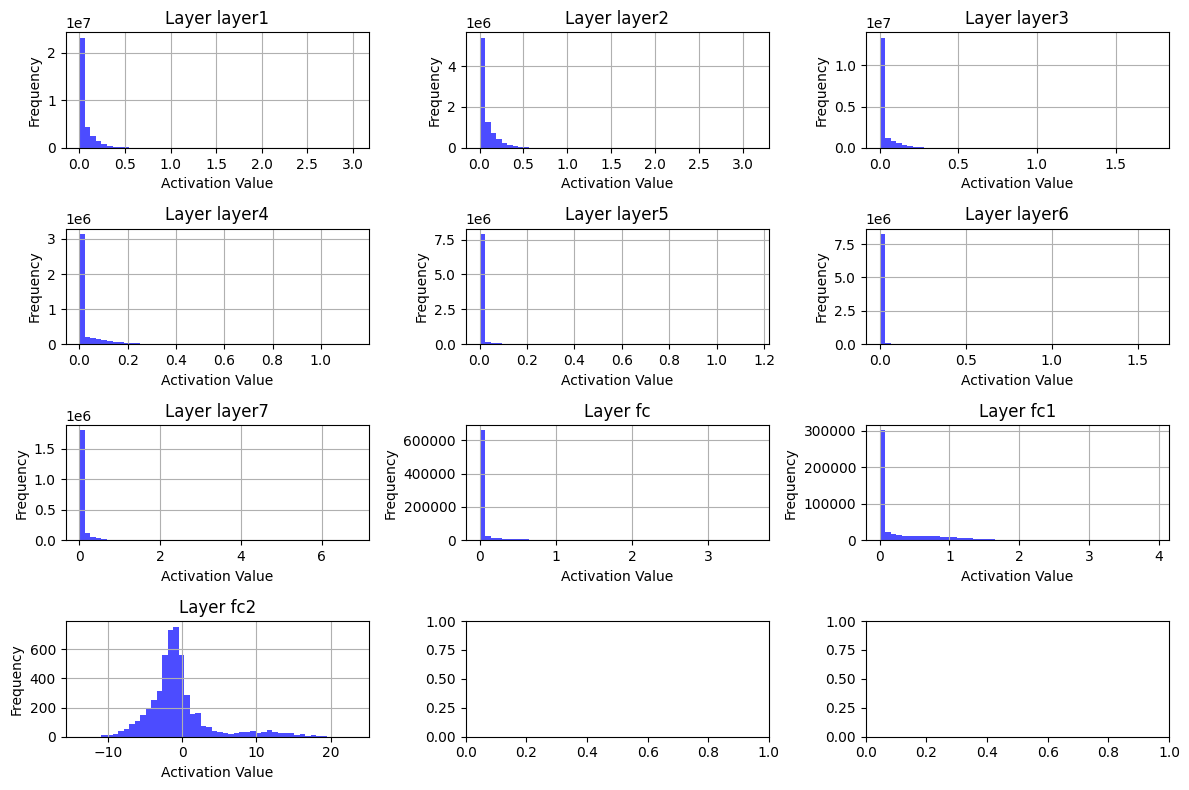

In [44]:
check_activation(loaded_model, dataloader['test'])